# Analysis of the t-SNE generated Global Health Index

## Libraries imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.manifold import TSNE

## Data imports

In [2]:
data = pd.read_csv("data_02.csv")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 49095: invalid start byte

In [4]:
var_names = pd.read_csv("data_names_var_index.csv")

var_names = var_names.drop(index=12).reset_index(drop=True) # We drop the variable RwSTATUS

RwAGEY_B = dict(zip(var_names.columns, ["cont"]+[f"R{wave}AGEY_B" for wave in range(1,15)]))
var_names = var_names.append(RwAGEY_B, ignore_index=True) # We add the age variable, as it is interesting

AttributeError: 'DataFrame' object has no attribute 'append'

In [49]:
health_index = pd.read_csv("/content/drive/MyDrive/Statapp/data_tSNE_GHI.csv")

In [5]:
in_waves = [f"INW{wave}" for wave in range(1, 15)]
health_variables = list(var_names.drop(columns="CAT_CONT").values.flatten())
health_data = data[["HHIDPN"] + in_waves + health_variables]

VÉRIFIER QUE LA LIGNE CI-DESSOUS EST À SA PLACE !

In [6]:
health_data = health_data.merge(health_index[["HHIDPN"] + [f"tSNE_GHI{wave}" for wave in range(1, 15)]], on="HHIDPN")

## Analysis of sensitivity

An analysis of sensitivity consists in testing the robustness of an index to changes in the data or in the assumptions made. We will conduct different scenarios with different input data and compare the results.

First, we select a random sample of the data to create the index on this data only, and compare the results.

In [7]:
def get_wave(df, wave):
  assert wave > 0
  assert wave <= 14
  assert isinstance(wave, int)

  health_variables_for_this_wave = list(var_names[f"health_var_{wave}"].values)

  return df.loc[df[f"INW{wave}"] == 1, health_variables_for_this_wave + ["HHIDPN"]]

In [ ]:
# We will calculate the index on different samples
n_individuals_possible = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
rmse_dataframe = np.zeros((14, len(n_individuals_possible)))

# We shall do the calculation multiple times to be sure it is statistically significative.
number_of_iterations = 1
for iteration in range(number_of_iterations):
  print("\n\nIteration " + str(iteration))

  for n_individuals in n_individuals_possible:
    print("\nNumber of individuals randomly selected: " + str(n_individuals))
    rand_data = data.sample(n=n_individuals, random_state = iteration) # We change the random_state at each iteration to not calculate the same thing again
    health_data_rand = rand_data[["HHIDPN"] + in_waves + health_variables]
    health_index_rand = rand_data[["HHIDPN"]+in_waves].copy() # We instantiate the empty dataframe

    for wave in range(1, 15):
      print(f"Wave {wave}", end=" - ")

      # Get data
      data_wave = get_wave(health_data_rand, wave)
      X = data_wave.drop(columns=["HHIDPN"]).values
      nb_wave_rand = data_wave.shape[0]
      nb_wave = data.loc[data[f"INW{wave}"] == 1].shape[0]

      # Preprocessing
      scaler = StandardScaler()
      X_scaled = scaler.fit_transform(X)

      # Imputing missing values
      imputer = IterativeImputer(max_iter=500)
      X_imputed = imputer.fit_transform(X_scaled)

      # Creating the index
      tSNE = TSNE(n_components=1) # We only take one component because we wish to create an index
      health_index_wave = tSNE.fit_transform(X_imputed) # Index created
      health_index_wave = StandardScaler(with_std=False).fit_transform(health_index_wave) # We mean-center the index

      # Storing the index
      health_index_rand.loc[health_index_rand[f"INW{wave}"]==1, f"tSNE_GHI{wave}"] = health_index_wave
    
    health_index_rand = health_index_rand.drop(columns = in_waves)
    health_index = pd.merge(health_index, health_index_rand, on="HHIDPN", how="inner", suffixes=('', f'_{n_individuals}'))

  # Collect metrics
  rmse_array = np.zeros((14, len(n_individuals_possible)))
  for i in range(len(n_individuals_possible)):
    n_individuals = n_individuals_possible[i]
    for wave in range(1, 15):
      health_index[f"Error_{n_individuals}_{wave}"] = health_index[f"tSNE_GHI{wave}"] - health_index[f"tSNE_GHI{wave}_{n_individuals}"]
      health_index[f"Error_{n_individuals}_{wave}"] = np.power(health_index[f"Error_{n_individuals}_{wave}"], 2)

    rmse_array[:, i] = np.sqrt(health_index[[f"Error_{n_individuals}_{wave}" for wave in range(1, 15)]].mean().values)

  rmse_dataframe += rmse_array

rmse_dataframe /= number_of_iterations # We don't forget to divide by the number of iterations to get the mean
rmse_dataframe = pd.DataFrame(rmse_array, columns = ["5000", "10000", "15000", "20000", "25000", "30000", "35000", "40000"])

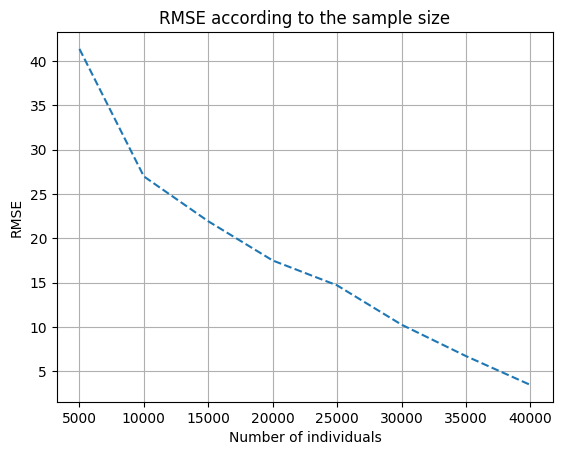

In [13]:
rmse_dataframe.mean().plot(ls = "--")
plt.title("RMSE according to the sample size")
plt.xlabel("Number of individuals")
plt.ylabel("RMSE")
plt.grid()
plt.show()

On the graph above, each point corresponds to a mean calculated over 5 simulations.

In [23]:
rmse_dataframe.mean()

5000     41.387510
10000    26.991857
15000    21.927010
20000    17.500652
25000    14.690540
30000    10.254316
35000     6.706729
40000     3.449914
dtype: float64

Now, we delete values at random in the initial dataframe, then create the index and compare the results.

In [ ]:
percent_missing_values = [0.2, 0.1, 0.075, 0.05, 0.025, 0.01]
rmse_dataframe_nan = np.zeros((14, len(percent_missing_values)))

# We shall do the calculation multiple times to be sure it is statistically significative.
number_of_iterations = 1
for iteration in range(number_of_iterations):
    print("\n\nIteration " + str(iteration))

    for percentage in percent_missing_values:
        print("\nPercentage of random missing values: " + str(percentage))
        data_nan = data.mask(np.random.random(data.shape) < percentage)
        health_data_nan = data_nan[["HHIDPN"] + in_waves + health_variables]
        health_index_nan = data_nan[["HHIDPN"]+in_waves].copy()

        for wave in range(1, 15):
            print(f"Wave {wave}:", end=" ")

            # Get data
            data_wave = get_wave(health_data_nan, wave)
            X = data_wave.drop(columns=["HHIDPN"]).values
            #print("Data saved", end=" ; ")

            # Preprocessing
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            #print("Data scaled", end=" ; ")

            # Imputing missing values
            imputer = IterativeImputer(max_iter=100+int(percentage)*200)
            X_imputed = imputer.fit_transform(X_scaled)
            #print("Missing values imputed", end=" ; ")
            
            # Creating the index
            tSNE = TSNE(n_components=1) # We only take one component because we wish to create an index
            health_index_wave = tSNE.fit_transform(X_imputed) # Index created
            health_index_wave = StandardScaler(with_std=False).fit_transform(health_index_wave) # We mean-center the index
            #print("Health index created", end=" ; ")

            # Storing the index
            health_index_nan.loc[health_index_nan[f"INW{wave}"]==1, f"tSNE_GHI{wave}"] = health_index_wave
            #print("Health index stored.\n")

        health_index_nan = health_index_nan.drop(columns = in_waves)
        health_index = pd.merge(health_index, health_index_nan, on="HHIDPN", how="inner", suffixes=('', f'_{percentage}'))

    # Collect metrics
    rmse_array = np.zeros((14, len(percent_missing_values)))
    for i in range(len(percent_missing_values)):
        percentage = percent_missing_values[i]
        for wave in range(1, 15):
            health_index[f"Error_{percentage}_{wave}"] = health_index[f"tSNE_GHI{wave}"] - health_index[f"tSNE_GHI{wave}_{percentage}"]
            health_index[f"Error_{percentage}_{wave}"] = np.power(health_index[f"Error_{percentage}_{wave}"], 2)

        rmse_array[:, i] = np.sqrt(health_index[[f"Error_{percentage}_{wave}" for wave in range(1, 15)]].mean().values)

    rmse_dataframe_nan += rmse_array

rmse_dataframe_nan /= number_of_iterations # We don't forget to divide by the number of iterations to get the mean

In [ ]:
rmse_dataframe_nan = pd.DataFrame(rmse_array, columns = ["20", "10", "7.5", "5", "2.5", "1"])
rmse_dataframe_nan.mean().plot(ls = "--")
plt.title("RMSE according to the percentage of random missing values")
plt.xlabel("Percentage of missing values")
plt.ylabel("RMSE")
plt.grid()
plt.show()
# voir fichier RMSE_according_to_percentage_NaN.png

## Analysis of relationships between the index and health variables

In [14]:
def plot_index(var, waves="all", how="mean", show=True, title=None, xlabel=None, ylabel="Global health index", label=None):
  """
  plot the index with respect to the given variable 'var'.
  """

  # We convert 'waves' parameter into a list of waves to iterate over.
  if isinstance(waves, str) and waves == "all":
    waves = range(1, 15)
  if isinstance(waves, int):
    waves = [waves]
  
  
  index_by_var = pd.DataFrame()
  for wave in waves:
    if isinstance(var, str):
      variable = "R" + str(wave) + var
    else:
      variable = var[waves.index(wave)]
    index_for_wave = health_data.loc[health_data[f"INW{wave}"] == 1, [variable, f"tSNE_GHI{wave}"]].groupby([variable]).mean()
    index_by_var = pd.merge(index_by_var, index_for_wave, how="outer", left_index=True, right_index=True)
  
 
  if not isinstance(var, str):
    var = var[0][2:]

  if label is None:
    label = var
  index_by_var.T.mean().plot(label=label)
  plt.grid()

  if xlabel is None:
    xlabel = var
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  if title is None:
    title = "tSNE GHI by " + var
  plt.title(title)

  if show:
    plt.show()

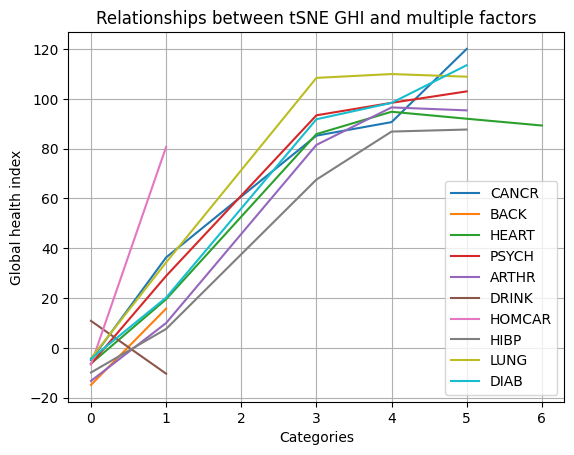

In [15]:
plot_index(var="CANCR", waves="all", show=False)
plot_index(var="BACK", waves="all", show=False)
plot_index(var="HEART", waves="all", show=False)
plot_index(var="PSYCH", waves="all", show=False)
plot_index(var="ARTHR", waves="all", show=False)
plot_index(var="DRINK", waves="all", show=False)
plot_index(var="HOMCAR", waves="all", show=False)
plot_index(var="HIBP", waves="all", show=False)
plot_index(var="LUNG", waves="all", show=False)
plot_index(var="DIAB", waves="all", show=False)

plt.legend()
plt.xlabel("Categories")
plt.title("Relationships between tSNE GHI and multiple factors")
plt.show()

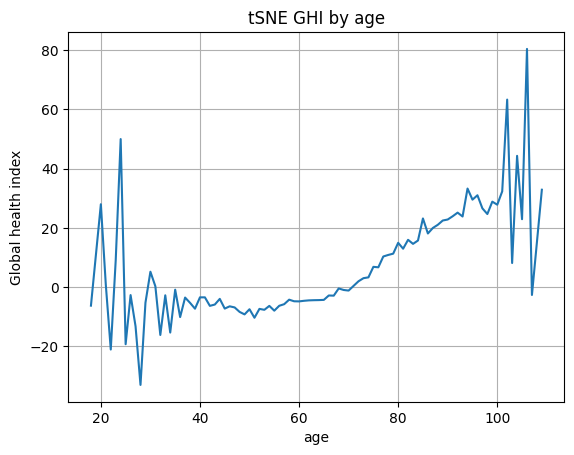

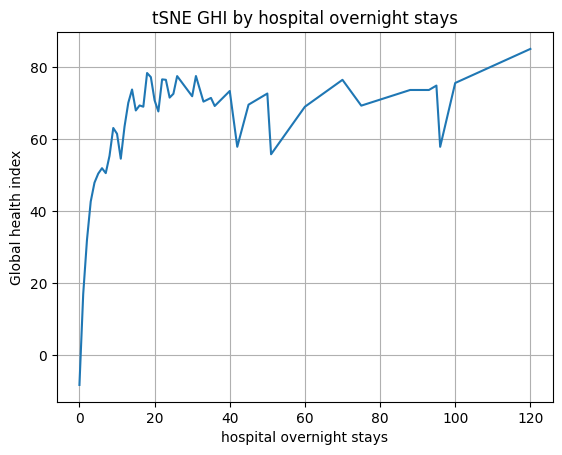

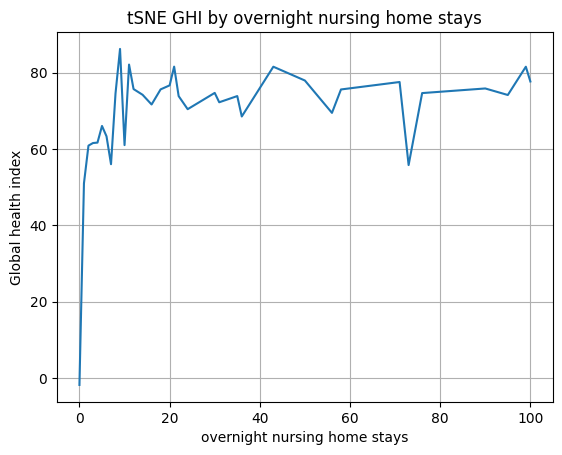

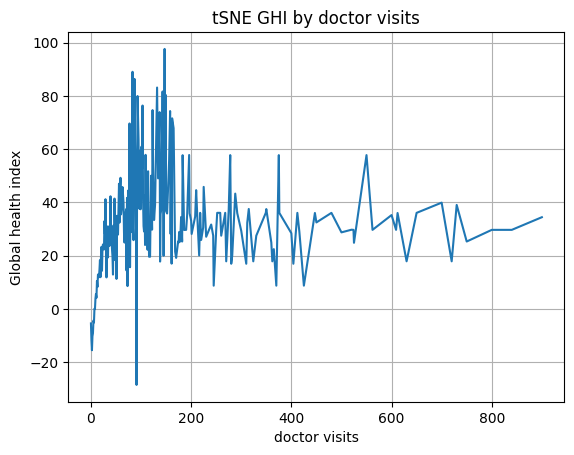

In [16]:
plot_index(var="AGEY_B", waves="all", show=True, title = "tSNE GHI by age", xlabel="age")
plot_index(var="HSPTIM", waves="all", show=True, title = "tSNE GHI by hospital overnight stays", xlabel="hospital overnight stays")
plot_index(var="NRSTIM", waves="all", show=True, title = "tSNE GHI by overnight nursing home stays", xlabel="overnight nursing home stays")
plot_index(var="DOCTIM", waves="all", show=True, title = "tSNE GHI by doctor visits", xlabel="doctor visits")

Overall, the index can be interpreted as a sign of bad health, in the way that all 'bad' behaviors affects it positively.

In short, the index is good.

## Evolution of the index across waves

We want to see whether the index is random for each individual over the waves.

In [55]:
# To simplify the analysis, we only focus on individuals that respondended to all waves
people_in_all_waves_health_index = health_index[[f"tSNE_GHI{wave}" for wave in range(1, 15)]].dropna().reset_index(drop=True) # shape = (3396, 14)

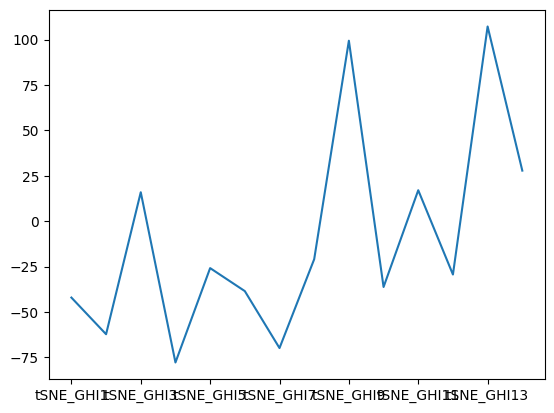

In [59]:
people_in_all_waves_health_index.iloc[3395, :].plot()
plt.show()